In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(3317)
plt.style.use("ggplot")


In [63]:
def load_mnist_3_8():
    """
    Load and preprocess MNIST dataset, filtering for digits 3 and 8.

    Returns:
        X_train, X_test, y_train, y_test: Training and test data and labels
    """
    # Load MNIST data
    mnist = fetch_openml("mnist_784", version=1)
    X, y = mnist.data.astype(float), mnist.target

    # Select only digits 3 and 8
    mask = (y == "3") | (y == "8")
    X, y = X.loc[mask].values, y.loc[mask].values

    # Convert labels to binary (0 for 3, 1 for 8)
    y = (y == "8").astype(int)

    # Normalize pixel values
    X = X / 255.0

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test


In [64]:
def initialize_parameters(m=784):
    """
    Initialize the model parameters.

    Args:
        m: Number of features (784 for MNIST)

    Returns:
        w: Initial weights
        b: Initial bias
    """
    np.random.seed(42)
    w = np.random.randn(m) * 0.01  # Small random values
    b = 0.0
    return w, b


In [65]:
def sigmoid(z):
    """
    Numerically stable sigmoid activation function.

    Args:
        z: Input values

    Returns:
        Sigmoid values
    """
    # Clip to avoid overflow
    z = np.clip(z, -500, 500)

    # Separate computation for positive and negative values for numerical stability
    mask = z >= 0
    result = np.zeros_like(z, dtype=float)

    # For z >= 0: 1 / (1 + exp(-z))
    result[mask] = 1.0 / (1.0 + np.exp(-z[mask]))

    # For z < 0: exp(z) / (1 + exp(z)) to avoid large exp(-z)
    exp_z = np.exp(z[~mask])
    result[~mask] = exp_z / (1.0 + exp_z)

    return result

In [66]:
def predict(X, w, b):
    """
    Make predictions using the logistic regression model.

    Args:
        X: Features
        w: Weights
        b: Bias

    Returns:
        Predicted probabilities
    """
    z = np.dot(X, w) + b
    return sigmoid(z)


In [67]:
def compute_loss(X, y, w, b, mu):
    """
    Compute the cross-entropy loss with L2 regularization.

    Args:
        X: Features
        y: True labels
        w: Weights
        b: Bias
        mu: Regularization parameter

    Returns:
        Total loss value
    """
    p = predict(X, w, b)

    # Avoid log(0) errors
    p = np.clip(p, 1e-15, 1 - 1e-15)

    # Cross-entropy loss
    cross_entropy = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # L2 regularization: (μ/2)(||w||² + b²)
    regularization = (mu / 2) * (np.sum(w**2) + b**2)

    return cross_entropy + regularization


In [68]:
def compute_gradients(X, y, w, b, mu):
    """
    Compute the gradients of the loss function with respect to parameters.

    Args:
        X: Features
        y: True labels
        w: Weights
        b: Bias
        mu: Regularization parameter

    Returns:
        dw: Gradient with respect to w
        db: Gradient with respect to b
    """
    n = len(y)
    p = predict(X, w, b)

    # Gradient for w
    dw = np.dot(X.T, (p - y)) / n + mu * w

    # Gradient for b
    db = np.sum(p - y) / n + mu * b

    return dw, db


In [69]:
def visualize_misclassifications(X, y, w, b, num_examples=5):
    """
    Visualize examples that were misclassified by the model.

    Args:
        X: Features
        y: True labels
        w: Trained weights
        b: Trained bias
        num_examples: Number of misclassified examples to show
    """
    # Get predictions
    p = predict(X, w, b)
    y_pred = (p >= 0.5).astype(int)

    # Find misclassified examples
    misclassified = np.where(y_pred != y)[0]

    if len(misclassified) == 0:
        print("No misclassified examples found!")
        return

    # Select a subset of misclassified examples
    indices = misclassified[: min(num_examples, len(misclassified))]

    # Plot the examples
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        img = X[idx].reshape(28, 28)
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(
            f"True: {3 if y[idx] == 0 else 8}\nPred: {3 if y_pred[idx] == 0 else 8}"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [70]:
def train_model(
    X_train,
    y_train,
    learning_rate,
    num_epochs,
    mu,
    method="vanilla",
    batch_size=10,
    diminishing_lr=False,
    verbose=True,
):
    """
    Train a logistic regression model using either vanilla gradient descent or mini-batch SGD.

    Args:
        X_train: Training features
        y_train: Training labels
        learning_rate: Initial learning rate for gradient updates
        num_epochs: Number of training epochs
        mu: Regularization parameter
        method: 'vanilla' for vanilla gradient descent or 'sgd' for mini-batch SGD
        batch_size: Size of mini-batches (only used if method='sgd')
        diminishing_lr: If True, use diminishing learning rate γ = learning_rate/t for SGD
        verbose: Whether to print progress

    Returns:
        w: Trained weights
        b: Trained bias
        loss_history: History of loss values during training
    """
    m = X_train.shape[1]  # Number of features (784 for MNIST)
    n = X_train.shape[0]  # Number of training examples

    # Initialize parameters
    w, b = initialize_parameters(m)

    # Initialize loss history
    loss_history = []

    # Loop over epochs
    for epoch in range(num_epochs):
        # Calculate current learning rate for SGD if using diminishing schedule
        current_lr = learning_rate
        if method == "sgd" and diminishing_lr:
            # t starts from 1, so epoch + 1
            current_lr = learning_rate / (epoch + 1)
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}: Current learning rate = {current_lr:.6f}")

        if method == "vanilla":
            # Vanilla gradient descent: compute gradients on entire dataset
            dw, db = compute_gradients(X_train, y_train, w, b, mu)

            # Update parameters
            w = w - learning_rate * dw
            b = b - learning_rate * db

        elif method == "sgd":
            # Mini-batch SGD: process data in batches

            # Shuffle data
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Process each mini-batch
            for i in range(0, n, batch_size):
                X_batch = X_shuffled[i : i + batch_size]
                y_batch = y_shuffled[i : i + batch_size]

                # Compute gradients on mini-batch
                dw, db = compute_gradients(X_batch, y_batch, w, b, mu)

                # Update parameters with current learning rate
                w = w - current_lr * dw
                b = b - current_lr * db
        else:
            raise ValueError("Method must be either 'vanilla' or 'sgd'")

        # Compute and store loss for the epoch
        loss = compute_loss(X_train, y_train, w, b, mu)
        loss_history.append(loss)

        # Print loss every 10 epochs as required
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

    return w, b, loss_history

In [71]:
def evaluate(X, y, w, b):
    """
    Evaluate the model on a given dataset.

    Args:
        X: Features
        y: True labels
        w: Weights
        b: Bias

    Returns:
        accuracy: Classification accuracy
    """
    p = predict(X, w, b)
    y_pred = (p >= 0.5).astype(int)
    accuracy = np.mean(y_pred == y)
    return accuracy


In [72]:
def logistic_regression_mnist_3_8(
    learning_rate,
    mu,
    num_epochs=100,
    method="vanilla",
    batch_size=32,
    diminishing_lr=False,
    verbose=True,
):
    """
    Train a logistic regression model to classify MNIST digits 3 and 8.

    Args:
        learning_rate: Initial learning rate for gradient descent
        mu: Regularization parameter
        num_epochs: Number of training epochs
        method: 'vanilla' for vanilla gradient descent or 'sgd' for mini-batch SGD
        batch_size: Size of mini-batches (only used if method='sgd')
        diminishing_lr: If True, use diminishing learning rate γ = learning_rate/t for SGD

    Returns:
        w: Trained weights
        b: Trained bias
        loss_history: Training loss after each epoch
        test_accuracy: Accuracy on the test set
    """
    # Load data
    X_train, X_test, y_train, y_test = load_mnist_3_8()

    lr_schedule = (
        "diminishing (1/t)" if diminishing_lr and method == "sgd" else "constant"
    )
    print(
        f"Training with method={method}, learning_rate={learning_rate} ({lr_schedule}), mu={mu}"
    )
    print(f"Dataset shape: X_train: {X_train.shape}, y_train: {y_train.shape}")

    # Train the model
    w, b, loss_history = train_model(
        X_train,
        y_train,
        learning_rate,
        num_epochs,
        mu,
        method,
        batch_size,
        diminishing_lr,
        verbose=verbose,
    )

    # Evaluate on test set
    test_accuracy = evaluate(X_test, y_test, w, b)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Plot loss history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(
        f"Training Loss (method={method}, lr={learning_rate} ({lr_schedule}), mu={mu})"
    )
    plt.grid(True)
    plt.show()

    return w, b, loss_history, test_accuracy

In [73]:
def compare_methods_and_hyperparameters(
    methods=["vanilla"],
    learning_rates=[0.001],
    batch_sizes=[10],
    mu=1.0,
    epochs=1000,
    diminishing_lr=False,
    verbose=True,
):
    """
    Compare vanilla gradient descent and mini-batch SGD with different hyperparameters.
    """

    results = []

    for method in methods:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(
                    f"\nTraining with method={method}, learning_rate={lr}, mu={mu}, batch_size={batch_size}"
                )

                # For SGD, use smaller number of epochs since each epoch involves multiple updates
                # epochs = 50 if method == "vanilla" else 20
                epochs = epochs

                w, b, loss_history, test_accuracy = logistic_regression_mnist_3_8(
                    lr,
                    mu,
                    num_epochs=epochs,
                    method=method,
                    batch_size=batch_size,
                    diminishing_lr=diminishing_lr,
                    verbose=verbose,
                )

                results.append(
                    {
                        "method": method,
                        "learning_rate": lr,
                        "mu": mu,
                        "final_loss": loss_history[-1],
                        "test_accuracy": test_accuracy,
                    }
                )

    # Print results table
    print("\nResults Summary:")
    print("-" * 100)
    print(
        f"{'Method':<10}{'Learning Rate':<15}{'Mu':<10}{'Final Loss':<15}{'Test Accuracy':<15}"
    )
    print("-" * 100)
    for result in results:
        print(
            f"{result['method']:<10}{result['learning_rate']:<15}{result['mu']:<10}"
            f"{result['final_loss']:<15.4f}{result['test_accuracy']:<15.4f}"
        )

    return results, w, b


Training with method=vanilla, learning_rate=0.001 (constant), mu=1
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Epoch 10/1000, Loss: 0.7333
Epoch 20/1000, Loss: 0.7244
Epoch 30/1000, Loss: 0.7159
Epoch 40/1000, Loss: 0.7077
Epoch 50/1000, Loss: 0.7000
Epoch 60/1000, Loss: 0.6925
Epoch 70/1000, Loss: 0.6853
Epoch 80/1000, Loss: 0.6785
Epoch 90/1000, Loss: 0.6720
Epoch 100/1000, Loss: 0.6657
Epoch 110/1000, Loss: 0.6597
Epoch 120/1000, Loss: 0.6539
Epoch 130/1000, Loss: 0.6484
Epoch 140/1000, Loss: 0.6431
Epoch 150/1000, Loss: 0.6380
Epoch 160/1000, Loss: 0.6332
Epoch 170/1000, Loss: 0.6285
Epoch 180/1000, Loss: 0.6240
Epoch 190/1000, Loss: 0.6197
Epoch 200/1000, Loss: 0.6156
Epoch 210/1000, Loss: 0.6116
Epoch 220/1000, Loss: 0.6078
Epoch 230/1000, Loss: 0.6042
Epoch 240/1000, Loss: 0.6006
Epoch 250/1000, Loss: 0.5973
Epoch 260/1000, Loss: 0.5940
Epoch 270/1000, Loss: 0.5909
Epoch 280/1000, Loss: 0.5879
Epoch 290/1000, Loss: 0.5850
Epoch 300/1000, Loss: 0.5823
Epoch 310/1000, 

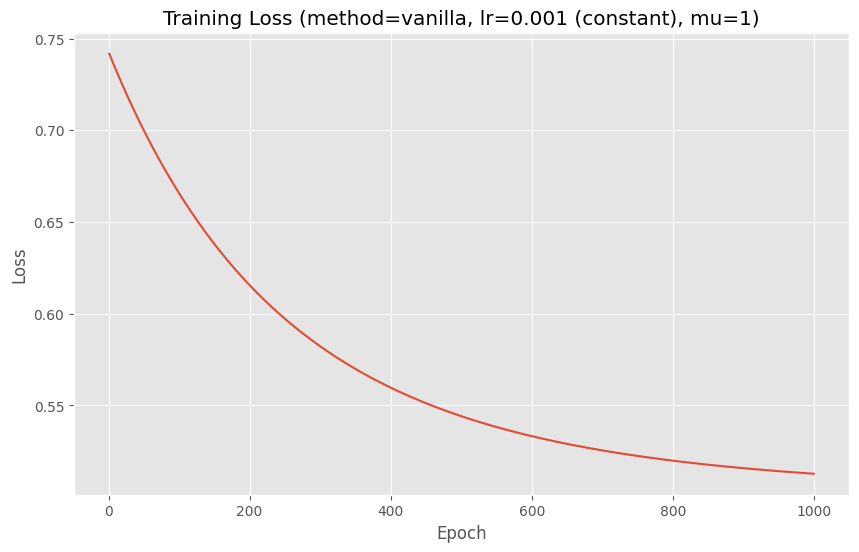

In [74]:
# Example usage
if __name__ == "__main__":
    # Single run with default values (vanilla gradient descent)
    learning_rate = 0.001
    mu = 1  # Regularization parameter
    num_epochs = 1000
    w, b, loss_history, test_accuracy = logistic_regression_mnist_3_8(
        learning_rate, mu, num_epochs=num_epochs, method="vanilla"
    )

    # # Single run with mini-batch SGD
    # w, b, loss_history, test_accuracy = logistic_regression_mnist_3_8(
    #     learning_rate, mu, num_epochs=num_epochs, method="sgd", batch_size=10
    # )

    # Uncomment to compare different methods and hyperparameters
    # results = compare_methods_and_hyperparameters(verbose=True)

    # results = compare_methods_and_hyperparameters(
    #     methods=["sgd"], batch_sizes=[1, 10, 100], epochs=100, verbose=True
    # )

    # results, w, b = compare_methods_and_hyperparameters(
    #     methods=["sgd"],
    #     batch_sizes=[10],
    #     epochs=100,
    #     diminishing_lr=False,
    #     verbose=True,
    # )

    # results, w, b = compare_methods_and_hyperparameters(
    #     methods=["sgd"],
    #     batch_sizes=[10],
    #     epochs=100,
    #     diminishing_lr=True,
    #     verbose=True,
    # )

    # # Visualize misclassifications
    # X_train, X_test, y_train, y_test = load_mnist_3_8()
    # visualize_misclassifications(X_test, y_test, w, b, num_examples=5)
